## Modeling

In [2]:
# %run functions_ml.ipynb

El conjunto de datos contiene características principales de las aplicaciones en el mercado de Google Play Store. 

Definición de variables:

- building_id  = Identificador único de la aplicación 


**damage_rate**

In [1]:
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
import xgboost as xgb 
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import date

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier

import lightgbm as lgb
from sklearn.svm import SVR
from xgboost import XGBClassifier
# from vecstack import stacking

pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 1000)

In [3]:
trainlabels = pd.read_csv("data/train_labels.csv")
dftrain = pd.read_csv("data/train_values.csv")
dftest = pd.read_csv("data/test_values.csv")
dfsample = pd.read_csv("data/submission_format.csv")
target = "damage_grade"

cols = dftrain.columns 
dftrain.columns = [i.lower().replace(" ", "_") for i in cols]

cols = dftest.columns
dftest.columns  = [i.lower().replace(" ", "_") for i in cols]

In [4]:
dftrain = pd.merge(dftrain, trainlabels, on = "building_id")

In [5]:
dftrain.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260601 entries, 0 to 260600
Data columns (total 40 columns):
 #   Column                                  Non-Null Count   Dtype 
---  ------                                  --------------   ----- 
 0   building_id                             260601 non-null  int64 
 1   geo_level_1_id                          260601 non-null  int64 
 2   geo_level_2_id                          260601 non-null  int64 
 3   geo_level_3_id                          260601 non-null  int64 
 4   count_floors_pre_eq                     260601 non-null  int64 
 5   age                                     260601 non-null  int64 
 6   area_percentage                         260601 non-null  int64 
 7   height_percentage                       260601 non-null  int64 
 8   land_surface_condition                  260601 non-null  object
 9   foundation_type                         260601 non-null  object
 10  roof_type                               260601 non-null 

In [6]:
# dftrain = preprocess_data(dftrain)
# dftest = preprocess_data(dftest)

In [7]:
dftrain[target].value_counts()

2    148259
3     87218
1     25124
Name: damage_grade, dtype: int64

In [9]:
dftest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86868 entries, 0 to 86867
Data columns (total 39 columns):
 #   Column                                  Non-Null Count  Dtype 
---  ------                                  --------------  ----- 
 0   building_id                             86868 non-null  int64 
 1   geo_level_1_id                          86868 non-null  int64 
 2   geo_level_2_id                          86868 non-null  int64 
 3   geo_level_3_id                          86868 non-null  int64 
 4   count_floors_pre_eq                     86868 non-null  int64 
 5   age                                     86868 non-null  int64 
 6   area_percentage                         86868 non-null  int64 
 7   height_percentage                       86868 non-null  int64 
 8   land_surface_condition                  86868 non-null  object
 9   foundation_type                         86868 non-null  object
 10  roof_type                               86868 non-null  object
 11  gr

In [12]:
dftrain.land_surface_condition.nunique()

3

In [15]:
dftrain.plan_configuration.nunique()

10

In [ ]:
'ground_floor_type', 'other_floor_type', 'position','plan_configuration'

In [19]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelBinarizer

dict_encoders = dict()

cols_to_dummies = ["foundation_type", "land_surface_condition", 
                   "roof_type", 'ground_floor_type', 
                   'other_floor_type', 'position','plan_configuration']

dftrain_tmp = dftrain.copy()
dftest_tmp = dftest.copy()

for col in cols_to_dummies:
    
    jobs_encoder = LabelBinarizer()
    jobs_encoder.fit(dftrain[col])

    transformed_train = jobs_encoder.transform(dftrain[col])
    transformed_test = jobs_encoder.transform(dftest[col]) 
    col_names = ["{}_{}".format(name_category, col) for name_category in jobs_encoder.classes_]
    ohe_df_trained = pd.DataFrame(transformed_train,  columns = col_names)
    ohe_df_test = pd.DataFrame(transformed_test,  columns = col_names)
    
    dftrain_tmp  = pd.concat([dftrain_tmp, ohe_df_trained], axis = 1)
    # .drop([col], axis = 1)
    dftest_tmp  = pd.concat([dftest_tmp, ohe_df_test], axis = 1)
    # .drop([col], axis = 1)

In [22]:
dftest_tmp.head()

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,h_foundation_type,i_foundation_type,r_foundation_type,u_foundation_type,w_foundation_type,n_land_surface_condition,o_land_surface_condition,t_land_surface_condition,n_roof_type,q_roof_type,x_roof_type,f_ground_floor_type,m_ground_floor_type,v_ground_floor_type,x_ground_floor_type,z_ground_floor_type,j_other_floor_type,q_other_floor_type,s_other_floor_type,x_other_floor_type,j_position,o_position,s_position,t_position,a_plan_configuration,c_plan_configuration,d_plan_configuration,f_plan_configuration,m_plan_configuration,n_plan_configuration,o_plan_configuration,q_plan_configuration,s_plan_configuration,u_plan_configuration
0,300051,17,596,11307,3,20,7,6,t,r,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0
1,99355,6,141,11987,2,25,13,5,t,r,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0
2,890251,22,19,10044,2,5,4,5,t,r,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0
3,745817,26,39,633,1,0,19,3,t,r,x,v,j,t,d,0,0,0,0,0,1,0,0,0,0,0,v,2,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0
4,421793,17,289,7970,3,15,8,7,t,r,q,f,q,t,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0


In [23]:
dftrain_ = dftrain_tmp.copy()
dftest_ = dftest_tmp.copy()


for type_id in ['plan_configuration', 'ground_floor_type', 'land_surface_condition']:
   
    for column_id, agg_func, func_name in [('age',np.mean,'avg'),
                                           ('age',np.var,'var'),
                                           ('age',np.max,'max'),
                                           ('count_floors_pre_eq', np.mean, 'avg'),
                                           ('age', np.min,'min'),
                                           ('age', np.mean, 'sum'),
                                           ('damage_grade', np.mean,'avg')]:
   
        tmp = dftrain_.groupby([type_id]).agg({column_id:agg_func}).reset_index()
        mean_df = dftrain_.groupby([type_id]).agg({column_id:agg_func}).reset_index()[[column_id, type_id]]
        mean_df.columns = [type_id+'_'+func_name+'_'+column_id, type_id]
        
        dftrain_ = pd.merge(dftrain_, mean_df,on = [type_id], how = 'left')
        dftest_ = pd.merge(dftest_, mean_df, on = [type_id], how = 'left')

### Clusterización

In [24]:
dftrain_.head(20)

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade,h_foundation_type,i_foundation_type,r_foundation_type,u_foundation_type,w_foundation_type,n_land_surface_condition,o_land_surface_condition,t_land_surface_condition,n_roof_type,q_roof_type,x_roof_type,f_ground_floor_type,m_ground_floor_type,v_ground_floor_type,x_ground_floor_type,z_ground_floor_type,j_other_floor_type,q_other_floor_type,s_other_floor_type,x_other_floor_type,j_position,o_position,s_position,t_position,a_plan_configuration,c_plan_configuration,d_plan_configuration,f_plan_configuration,m_plan_configuration,n_plan_configuration,o_plan_configuration,q_plan_configuration,s_plan_configuration,u_plan_configuration,plan_configuration_avg_age,plan_configuration_var_age,plan_configuration_max_age,plan_configuration_avg_count_floors_pre_eq,plan_configuration_min_age,plan_configuration_sum_age,plan_configuration_avg_damage_grade,ground_floor_type_avg_age,ground_floor_type_var_age,ground_floor_type_max_age,ground_floor_type_avg_count_floors_pre_eq,ground_floor_type_min_age,ground_floor_type_sum_age,ground_floor_type_avg_damage_grade,land_surface_condition_avg_age,land_surface_condition_var_age,land_surface_condition_max_age,land_surface_condition_avg_count_floors_pre_eq,land_surface_condition_min_age,land_surface_condition_sum_age,land_surface_condition_avg_damage_grade
0,802906,6,487,12198,2,30,6,5,t,r,n,f,q,t,d,1,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,3,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,26.563290,5378.810939,995,2.133470,0,26.563290,2.243646,28.119302,5762.330155,995,2.150306,0,28.119302,2.309104,27.144936,5767.077057,995,2.144849,0,27.144936,2.234170
1,28830,8,900,2812,2,10,8,7,o,r,n,x,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,2,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,26.563290,5378.810939,995,2.133470,0,26.563290,2.243646,25.098686,2996.097955,995,2.132331,0,25.098686,2.250714,20.199014,2093.469108,995,2.036917,0,20.199014,2.289081
2,94947,21,363,8973,2,10,5,5,t,r,n,f,x,t,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,3,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,26.563290,5378.810939,995,2.133470,0,26.563290,2.243646,28.119302,5762.330155,995,2.150306,0,28.119302,2.309104,27.144936,5767.077057,995,2.144849,0,27.144936,2.234170
3,590882,22,418,10694,2,10,6,5,t,r,n,f,x,s,d,0,1,0,0,0,0,1,1,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,2,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,26.563290,5378.810939,995,2.133470,0,26.563290,2.243646,28.119302,5762.330155,995,2.150306,0,28.119302,2.309104,27.144936,5767.077057,995,2.144849,0,27.144936,2.234170
4,201944,11,131,1488,3,30,8,9,t,r,n,f,x,s,d,1,0,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,3,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,26.563290,5378.810939,995,2.133470,0,26.563290,2.243646,28.119302,5762.330155,995,2.150306,0,28.119302,2.309104,27.144936,5767.077057,995,2.144849,0,27.144936,2.234170
5,333020,8,558,6089,2,10,9,5,t,r,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,1,1,0,0,0,0,0,0,0,0,0,2,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0

In [25]:
# cols_fill = ['age', 'count_floors_pre_eq', 'area_percentage', 'height_percentage']

# for col_fill  in cols_fill:
#     dftrain_[col_fill]  = dftrain_[col_fill].fillna(0)
#     dftest_[col_fill]  = dftest_[col_fill].fillna(0)

In [25]:
cols_cluster = ['age', 'count_floors_pre_eq', 'area_percentage', 'height_percentage']

In [26]:
from scipy.spatial.distance import cdist, pdist
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import euclidean_distances, silhouette_score

X = dftrain_[cols_cluster].fillna(0.0)

scaler = StandardScaler()
X_std = scaler.fit_transform(X)

K = range(1, 20)

KM = [KMeans(n_clusters = k).fit(X_std) for k in K]
centroids = [k.cluster_centers_ for k in KM]
D_k = [cdist(X_std, cent, 'euclidean') for cent in centroids]
dist = [np.min(D,axis=1) for D in D_k]
avgWithinSS = [sum(d)/X_std.shape[0] for d in dist]

In [6]:
# wcss = [sum(d**2) for d in dist]
# tss  = sum(pdist(X)**2)/X.shape[0]
# bss  = tss-wcss
# kIdx = 10-1

# fig, axs = plt.subplots( 1, 2, sharey = False, figsize = (23,7))
# axs[0].plot(K, avgWithinSS, 'b*-')
# axs[1].plot(K, bss/tss*100, 'b.--')


# ### Elbow plot
# axs[0].grid(False, which = "major", axis = "y")
# axs[0].set_xlabel('Number of clusters')
# axs[0].set_ylabel('Average within-cluster sum of squares')
# axs[0].set_title('Elbow for KMeans clustering')


# ### Variance explained
# axs[1].grid(False, which = "major", axis = "y")
# axs[1].set_xlabel('Number of clusters')
# axs[1].set_ylabel('Percentage of variance explained')
# axs[1].set_title('Elbow for KMeans clustering');

In [29]:
cols_cluster

['age', 'count_floors_pre_eq', 'area_percentage', 'height_percentage']

In [28]:
from scipy.spatial.distance import cdist, pdist
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import euclidean_distances, silhouette_score

X = dftrain_[cols_cluster].fillna(dftrain_[cols_cluster].mean(axis = 0))

scaler = StandardScaler()
X_std = scaler.fit_transform(X)

cluster = KMeans(n_clusters = 7, random_state = 94)
dftrain_['cluster'] = cluster.fit_predict(X_std)
dftrain_.cluster.value_counts()

0    93097
1    57165
5    53167
4    38136
6    10967
3     6679
2     1390
Name: cluster, dtype: int64

In [30]:
X_test_cluster = dftest_[cols_cluster].fillna(dftest_[cols_cluster].mean(axis = 0))
X_std_test = scaler.transform(X_test_cluster)
dftest_["cluster"] = cluster.predict(X_std_test)
dftest_["cluster"].value_counts()

0    31321
1    18989
5    17697
4    12517
6     3600
3     2283
2      461
Name: cluster, dtype: int64

In [31]:
dftest_.info(null_counts = True, verbose = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 86868 entries, 0 to 86867
Data columns (total 95 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   building_id                                     86868 non-null  int64  
 1   geo_level_1_id                                  86868 non-null  int64  
 2   geo_level_2_id                                  86868 non-null  int64  
 3   geo_level_3_id                                  86868 non-null  int64  
 4   count_floors_pre_eq                             86868 non-null  int64  
 5   age                                             86868 non-null  int64  
 6   area_percentage                                 86868 non-null  int64  
 7   height_percentage                               86868 non-null  int64  
 8   land_surface_condition                          86868 non-null  object 
 9   foundation_type                        

C:\Users\Voxiva\Anaconda2\envs\caleraenv\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: null_counts is deprecated. Use show_counts instead
  """Entry point for launching an IPython kernel.


In [32]:
dftest_.select_dtypes(include=['int64', 'float64', 'int']).columns

Index(['building_id', 'geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id',
       'count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage',
       'has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone',
       'has_superstructure_stone_flag',
       'has_superstructure_cement_mortar_stone',
       'has_superstructure_mud_mortar_brick',
       'has_superstructure_cement_mortar_brick', 'has_superstructure_timber',
       'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered',
       'has_superstructure_rc_engineered', 'has_superstructure_other',
       'count_families', 'has_secondary_use', 'has_secondary_use_agriculture',
       'has_secondary_use_hotel', 'has_secondary_use_rental',
       'has_secondary_use_institution', 'has_secondary_use_school',
       'has_secondary_use_industry', 'has_secondary_use_health_post',
       'has_secondary_use_gov_office', 'has_secondary_use_use_police',
       'has_secondary_use_other', 'h_foundation_type', 'i_f

### Target Encoding

-  This code was taken from https://www.kaggle.com/ogrellier/python-target-encoding-for-categorical-features

In [79]:
def add_noise(series, noise_level):
    return series * (1 + noise_level * np.random.randn(len(series)))

def target_encode(trn_series=None, 
                  tst_series=None, 
                  target=None, 
                  min_samples_leaf=1, 
                  smoothing=1,
                  noise_level=0):
    """
    Smoothing is computed like in the following paper by Daniele Micci-Barreca
    https://kaggle2.blob.core.windows.net/forum-message-attachments/225952/7441/high%20cardinality%20categoricals.pdf
    trn_series : training categorical feature as a pd.Series
    tst_series : test categorical feature as a pd.Series
    target : target data as a pd.Series
    min_samples_leaf (int) : minimum samples to take category average into account
    smoothing (int) : smoothing effect to balance categorical average vs prior  
    """ 
    assert len(trn_series) == len(target)
    assert trn_series.name == tst_series.name
    temp = pd.concat([trn_series, target], axis=1)
    # Compute target mean 
    averages = temp.groupby(by=trn_series.name)[target.name].agg(["mean", "count"])
    # Compute smoothing
    smoothing = 1 / (1 + np.exp(-(averages["count"] - min_samples_leaf) / smoothing))
    # Apply average function to all target data
    prior = target.mean()
    # The bigger the count the less full_avg is taken into account
    averages[target.name] = prior * (1 - smoothing) + averages["mean"] * smoothing
    averages.drop(["mean", "count"], axis=1, inplace=True)
    # Apply averages to trn and tst series
    ft_trn_series = pd.merge(
        trn_series.to_frame(trn_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=trn_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_trn_series.index = trn_series.index 
    ft_tst_series = pd.merge(
        tst_series.to_frame(tst_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=tst_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_tst_series.index = tst_series.index
    return add_noise(ft_trn_series, noise_level), add_noise(ft_tst_series, noise_level)

In [80]:
cols_for_tencoding = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']
for cl in cols_for_tencoding:

    trn, sub = target_encode(dftrain_[cl], 
                             dftest_[cl], 
                             target=dftrain_[target], 
                             min_samples_leaf = 100,
                             smoothing=10, noise_level = 0.01)
    
    dftrain_[f'{cl}_te'] = trn
    dftest_[f'{cl}_te'] = sub

In [85]:
dftest_.info(null_counts = True, verbose = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86868 entries, 0 to 86867
Data columns (total 105 columns):
 #    Column                                          Non-Null Count  Dtype  
---   ------                                          --------------  -----  
 0    building_id                                     86868 non-null  int64  
 1    geo_level_1_id                                  86868 non-null  int64  
 2    geo_level_2_id                                  86868 non-null  int64  
 3    geo_level_3_id                                  86868 non-null  int64  
 4    count_floors_pre_eq                             86868 non-null  int64  
 5    age                                             86868 non-null  int64  
 6    area_percentage                                 86868 non-null  int64  
 7    height_percentage                               86868 non-null  int64  
 8    land_surface_condition                          86868 non-null  object 
 9    foundation_type           

C:\Users\Voxiva\Anaconda2\envs\caleraenv\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: null_counts is deprecated. Use show_counts instead
  """Entry point for launching an IPython kernel.


In [27]:
dftrain_['volume_percentage'] = dftrain_['area_percentage'] * dftrain_['height_percentage']
dftest_['volume_percentage'] = dftest_['area_percentage'] * dftest_['height_percentage']

In [28]:
def apply_log_transformation(df, cols, func):
    for cl in cols:
        df["{}_log".format(cl)] = func(df[cl])
    return df

In [31]:
cols_to_transform = ["age", "count_floors_pre_eq", "area_percentage", 
                     "height_percentage", "volume_percentage", 
                     "count_families"]

dftrain_ = apply_log_transformation(dftrain_, cols_to_transform,np.log1p )
dftest_ = apply_log_transformation(dftest_, cols_to_transform,np.log1p )

In [87]:
dftrain_.to_csv("data/dftrain_preprocess.csv", index = False)
dftest_.to_csv("data/dftest_preprocess.csv", index = False)

In [26]:
dftrain_ = pd.read_csv("data/dftrain_preprocess.csv")
dftest_  = pd.read_csv("data/dftest_preprocess.csv")

----

In [89]:
list(dftrain_.columns)

['building_id',
 'geo_level_1_id',
 'geo_level_2_id',
 'geo_level_3_id',
 'count_floors_pre_eq',
 'age',
 'area_percentage',
 'height_percentage',
 'land_surface_condition',
 'foundation_type',
 'roof_type',
 'ground_floor_type',
 'other_floor_type',
 'position',
 'plan_configuration',
 'has_superstructure_adobe_mud',
 'has_superstructure_mud_mortar_stone',
 'has_superstructure_stone_flag',
 'has_superstructure_cement_mortar_stone',
 'has_superstructure_mud_mortar_brick',
 'has_superstructure_cement_mortar_brick',
 'has_superstructure_timber',
 'has_superstructure_bamboo',
 'has_superstructure_rc_non_engineered',
 'has_superstructure_rc_engineered',
 'has_superstructure_other',
 'legal_ownership_status',
 'count_families',
 'has_secondary_use',
 'has_secondary_use_agriculture',
 'has_secondary_use_hotel',
 'has_secondary_use_rental',
 'has_secondary_use_institution',
 'has_secondary_use_school',
 'has_secondary_use_industry',
 'has_secondary_use_health_post',
 'has_secondary_use_gov_of

In [92]:
cols_train = ['geo_level_1_id_te', 'geo_level_2_id_te', 'geo_level_3_id_te',
       'count_floors_pre_eq_log', 'age_log', 'area_percentage_log', 
       'height_percentage_log', 'volume_percentage_log',
       'count_families_log',
       'has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone',
       'has_superstructure_stone_flag',
       'has_superstructure_cement_mortar_stone',
       'has_superstructure_mud_mortar_brick',
       'has_superstructure_cement_mortar_brick', 'has_superstructure_timber',
       'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered',
       'has_superstructure_rc_engineered', 'has_superstructure_other',
       'has_secondary_use', 'has_secondary_use_agriculture',
       'has_secondary_use_hotel', 'has_secondary_use_rental',
       'has_secondary_use_institution', 'has_secondary_use_school',
       'has_secondary_use_industry', 'has_secondary_use_health_post',
       'has_secondary_use_gov_office', 'has_secondary_use_use_police',
       'has_secondary_use_other', 'h_foundation_type', 'i_foundation_type',
       'r_foundation_type', 'u_foundation_type', 'w_foundation_type',
       'n_land_surface_condition', 'o_land_surface_condition',
       't_land_surface_condition', 'n_roof_type', 'q_roof_type', 'x_roof_type',
       'f_ground_floor_type', 'm_ground_floor_type', 'v_ground_floor_type',
       'x_ground_floor_type', 'z_ground_floor_type', 'j_other_floor_type',
       'q_other_floor_type', 's_other_floor_type', 'x_other_floor_type',
       'j_position', 'o_position', 's_position', 't_position',
       'a_plan_configuration', 'c_plan_configuration', 'd_plan_configuration',
       'f_plan_configuration', 'm_plan_configuration', 'n_plan_configuration',
       'o_plan_configuration', 'q_plan_configuration', 's_plan_configuration',
       'u_plan_configuration', 
       'cluster']

print(len(cols_train))

66


In [93]:
dftrain_[cols_train].head()

,geo_level_1_id_te,geo_level_2_id_te,geo_level_3_id_te,count_floors_pre_eq_log,age_log,area_percentage_log,height_percentage_log,volume_percentage_log,count_families_log,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,h_foundation_type,i_foundation_type,r_foundation_type,u_foundation_type,w_foundation_type,n_land_surface_condition,o_land_surface_condition,t_land_surface_condition,n_roof_type,q_roof_type,x_roof_type,f_ground_floor_type,m_ground_floor_type,v_ground_floor_type,x_ground_floor_type,z_ground_floor_type,j_other_floor_type,q_other_floor_type,s_other_floor_type,x_other_floor_type,j_position,o_position,s_position,t_position,a_plan_configuration,c_plan_configuration,d_plan_configuration,f_plan_configuration,m_plan_configuration,n_plan_configuration,o_plan_configuration,q_plan_configuration,s_plan_configuration,u_plan_configuration,cluster
0,2.122185,2.784377,2.230988,1.098612,3.433987,1.945910,1.791759,3.433987,0.693147,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0
1,2.528835,2.506623,2.227465,1.098612,2.397895,2.197225,2.079442,4.043051,0.693147,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1
2,2.563143,2.539790,2.578866,1.098612,2.397895,1.791759,1.791759,3.258097,0.693147,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0
3,2.002747,2.119239,2.218132,1.098612,2.397895,1.945910,1.791759,3.433987,0.693147,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0
4,2.338896,2.291436,2.335761,1.386294,3.433987,2.197225,2.302585,4.290459,0.693147,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,5


In [38]:
dftrain_[cols_train+[target]].corr().loc[target].sort_values()

v_ground_floor_type                      -0.318720
x_roof_type                              -0.280106
i_foundation_type                        -0.263901
has_superstructure_cement_mortar_brick   -0.254131
s_other_floor_type                       -0.226820
has_superstructure_rc_engineered         -0.179014
w_foundation_type                        -0.173328
has_superstructure_rc_non_engineered     -0.158145
u_foundation_type                        -0.139452
j_other_floor_type                       -0.135668
area_percentage_log                      -0.113114
has_secondary_use_hotel                  -0.097942
has_secondary_use_rental                 -0.083754
has_secondary_use                        -0.079630
has_superstructure_timber                -0.069852
has_superstructure_bamboo                -0.063051
u_plan_configuration                     -0.062317
has_superstructure_cement_mortar_stone   -0.060295
volume_percentage_log                    -0.037996
j_position                     

In [39]:
dftrain_[target].value_counts()

2    148259
3     87218
1     25124
Name: damage_grade, dtype: int64

<AxesSubplot:>

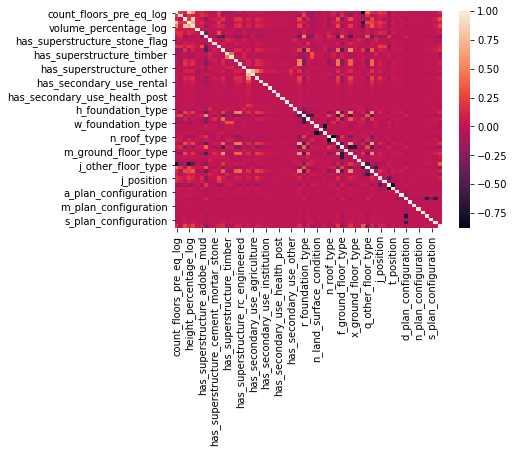

In [40]:
sns.heatmap(dftrain_[cols_train].corr())

### Validation

In [94]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error
from sklearn.linear_model import LinearRegression

In [95]:
X_train, y_train = dftrain_.loc[:, cols_train], dftrain_.loc[:,target]
X_test = dftest_.loc[:, cols_train]

In [96]:
from sklearn.preprocessing import StandardScaler, MaxAbsScaler, MinMaxScaler, RobustScaler
std_scaler = RobustScaler()
X_train_encode = std_scaler.fit_transform(X_train[cols_train])
X_train_encode = pd.DataFrame(X_train_encode)
# X_train_encode.columns = cols_train
X_train_encode.index = y_train.index
X_test_encode = std_scaler.transform(X_test[cols_train])
X_test_encode = pd.DataFrame(X_test_encode)

In [97]:
from sklearn.metrics import f1_score, f1_score
from sklearn.metrics import log_loss

In [98]:
X_train[cols_train].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260601 entries, 0 to 260600
Data columns (total 66 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   geo_level_1_id_te                       260601 non-null  float64
 1   geo_level_2_id_te                       260601 non-null  float64
 2   geo_level_3_id_te                       260601 non-null  float64
 3   count_floors_pre_eq_log                 260601 non-null  float64
 4   age_log                                 260601 non-null  float64
 5   area_percentage_log                     260601 non-null  float64
 6   height_percentage_log                   260601 non-null  float64
 7   volume_percentage_log                   260601 non-null  float64
 8   count_families_log                      260601 non-null  float64
 9   has_superstructure_adobe_mud            260601 non-null  int64  
 10  has_superstructure_mud_mortar_stone     2606

In [99]:
%%time
#### xgboost

model_xgb = xgb.XGBClassifier(learning_rate = 0.01, n_estimators = 700, 
                              max_depth = 10, 
                              booster  = "gbtree", 
                              importance_type = "gain")

model_xgb.fit(X_train[cols_train], y_train, verbose = True)

C:\Users\Voxiva\Anaconda2\envs\caleraenv\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:55:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Wall time: 8min 24s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=700, n_jobs=8, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [102]:
y_pred_xgb_probs = model_xgb.predict(X_test[cols_train])

In [103]:
np.unique(y_pred_xgb_probs, return_counts=True)

(array([1, 2, 3], dtype=int64), array([ 5711, 57778, 23379], dtype=int64))

In [63]:
np.unique(y_pred_xgb_probs, return_counts=True)

(array([1, 2, 3], dtype=int64), array([ 6495, 55934, 24439], dtype=int64))

In [48]:
np.unique(y_pred_xgb_probs, return_counts=True)

(array([1, 2, 3], dtype=int64), array([ 4897, 67856, 14115], dtype=int64))

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

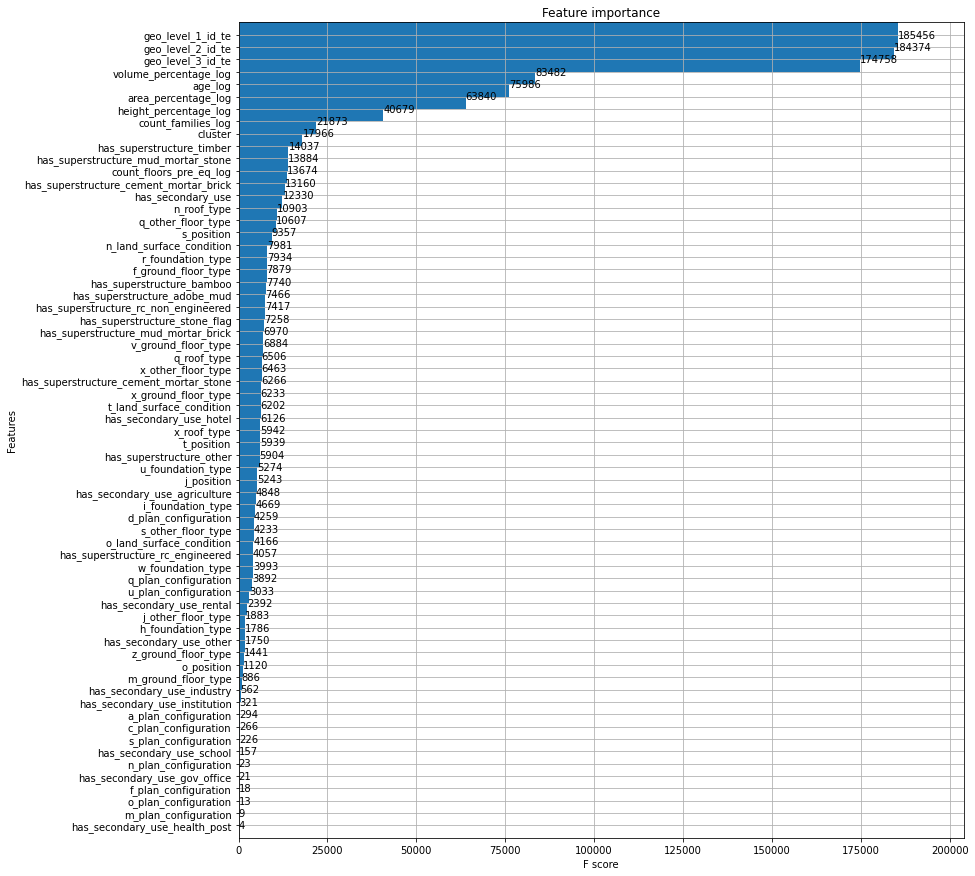

In [104]:
from xgboost import plot_importance
figsize = (13, 15)
fig, ax = plt.subplots(1, 1, figsize = figsize)
plot_importance(model_xgb, height = 2, ax = ax)

In [105]:
dfsample[target] = y_pred_xgb_probs
dfsample.columns = ["building_id", target]
dfsample[["building_id", target]].to_csv("data/submission_{}_xgb.csv".format(datetime.now().strftime("%Y%m%d%H%M%S")), index=False)
dfsample[target].value_counts()

2    57778
3    23379
1     5711
Name: damage_grade, dtype: int64

### Random Forest

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

In [22]:
pipe = make_pipeline(RandomForestClassifier(random_state = 94))

In [23]:
param_grid = {'randomforestclassifier__n_estimators': [300, 500, 700, 1000],
              'randomforestclassifier__min_samples_leaf': [1, 5, 10]}

gs = GridSearchCV(pipe, param_grid, cv = 4)

In [24]:
gs.fit(X_train, y_train)

KeyboardInterrupt: 

#### lighgbm

In [123]:
# X_test[cols_train].info(verbose = True, null_counts = True)

In [81]:
import lightgbm as lgb

model_lgb = lgb.LGBMClassifier(objective ='multiclass',
    n_estimators = 1000,
    boosting_type='gbdt',
    learning_rate = 0.001,
    max_depth = 10, 
    verbose = 1, 
    seed = 94)

model_lgb.fit(X_train[cols_train], y_train)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017700 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 795
[LightGBM] [Info] Number of data points in the train set: 260601, number of used features: 36
[LightGBM] [Info] Start training from score -2.339167
[LightGBM] [Info] Start training from score -0.564030
[LightGBM] [Info] Start training from score -1.094580


LGBMClassifier(learning_rate=0.001, max_depth=10, n_estimators=1000,
               objective='multiclass', seed=94, verbose=1)

In [82]:
y_pred_lgb_probs = model_lgb.predict(X_test[cols_train])

In [83]:
dfsample[target] = y_pred_lgb_probs
dfsample.columns = ["building_id", target]
dfsample[["building_id", target]].to_csv("data/submission_{}_lightgbm.csv".format(datetime.now().strftime("%Y%m%d")), index=False)
dfsample[target].value_counts()

2    70594
3    15525
1      749
Name: damage_grade, dtype: int64

In [ ]:
X_test.info()

### Ensamblado

In [93]:
from vecstack import stacking
X_train_col, y_train_col = dftrain_.loc[:, cols_train], dftrain_.loc[:,target]
X_test_col = dftest_.loc[:, cols_train]


models_col = [
            lgb.LGBMClassifier(boosting_type = 'gbdt',
                      learning_rate= 0.001, 
                      n_estimators = 400,
                       objective="multiclass",
                      max_depth = 5),
    
    XGBClassifier(random_state=0, n_jobs=-1, 
                  learning_rate= 0.002, 
             n_estimators=400, max_depth=5, 
                  objective="objective=multi:softmax"),
    
    XGBClassifier(random_state = 10, 
                  n_jobs=-1, learning_rate=0.001, 
                 n_estimators=1000, 
                  max_depth=10, 
                  objective="objective=multi:softmax"),
    
    
    lgb.LGBMClassifier(boosting_type = 'goss',
                      learning_rate= 0.001, 
                      n_estimators = 300, 
                     objective="multiclass",
                      max_depth = 3)
]


S_train_col, S_test_col = stacking(models_col,                     # list of models
                           X_train_col, y_train_col, X_test_col,   # data
                           regression = False,            # regression task (if you need 
                                                       #     classification - set to False)
                           mode = 'oof_pred',        # mode: oof for train set, predict test 

                           save_dir = None,              # do not save result and log (to save 
                           needs_proba = False,                            #     in current dir - set to '.')
                           metric = log_loss, # metric: callable
                           n_folds = 2,                  # number of folds
                           shuffle = True,               # shuffle the data
                           stratified=True,
                           random_state = 0,             # ensure reproducibility
                           verbose = 2)                  # print all info

task:         [classification]
n_classes:    [3]
metric:       [accuracy_score]
mode:         [oof_pred]
n_models:     [4]

model  0:     [LGBMClassifier]
    fold  0:  [0.62773118]
    fold  1:  [0.62861090]
    ----
    MEAN:     [0.62817104] + [0.00043986]
    FULL:     [0.62817104]

    Fitting on full train set...

model  1:     [XGBClassifier]


C:\Users\Voxiva\Anaconda2\envs\udacityenv\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[02:59:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
    fold  0:  [0.65529044]


C:\Users\Voxiva\Anaconda2\envs\udacityenv\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[02:59:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
    fold  1:  [0.65600153]
    ----
    MEAN:     [0.65564599] + [0.00035555]
    FULL:     [0.65564599]

    Fitting on full train set...



C:\Users\Voxiva\Anaconda2\envs\udacityenv\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[03:00:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
model  2:     [XGBClassifier]


C:\Users\Voxiva\Anaconda2\envs\udacityenv\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[03:01:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
    fold  0:  [0.69540525]


C:\Users\Voxiva\Anaconda2\envs\udacityenv\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[03:05:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
    fold  1:  [0.69361474]
    ----
    MEAN:     [0.69450999] + [0.00089526]
    FULL:     [0.69451000]

    Fitting on full train set...



C:\Users\Voxiva\Anaconda2\envs\udacityenv\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[03:09:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
model  3:     [LGBMClassifier]
    fold  0:  [0.56891352]
    fold  1:  [0.56891021]
    ----
    MEAN:     [0.56891186] + [0.00000165]
    FULL:     [0.56891186]

    Fitting on full train set...



In [94]:
S_test_col

array([[3, 3, 3, 2],
       [2, 2, 2, 2],
       [2, 2, 2, 2],
       ...,
       [2, 2, 2, 2],
       [2, 2, 2, 2],
       [2, 2, 1, 2]])

In [103]:
y_pred_col_stack  = S_test_col[:,0::2].mean(axis = 1)

In [105]:
np.unique(np.floor(y_pred_col_stack), return_counts=True)

(array([1., 2., 3.]), array([ 4559, 74979,  7330], dtype=int64))

In [108]:
dfsample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86868 entries, 0 to 86867
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   building_id   86868 non-null  int64  
 1   damage_grade  86868 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 1.3 MB


In [112]:
dfsample[target] = np.floor(y_pred_col_stack)
dfsample.columns = ["building_id", target]
dfsample[target] = dfsample[target].astype(int)
dfsample[["building_id", target]].to_csv("data/submission_{}_stack.csv".format(datetime.now().strftime("%Y%m%d")), index=False)
dfsample[target].value_counts()

2    74979
3     7330
1     4559
Name: damage_grade, dtype: int64

### neural net

In [115]:
import tensorflow as tf
from keras import losses
from keras import metrics
from keras import optimizers

In [117]:
len(cols_train)

37

In [116]:
from sklearn.model_selection import train_test_split

X_train_partial, X_valid, y_train_partial, y_valid = train_test_split(X_train_encode, y_train,
                                                                      test_size = 0.3, 
                                                                      random_state = 94, 
                                                                      stratify = y_train)

In [125]:
num_epochs = 500
batch_size = 128 

model_total = tf.keras.Sequential()
model_total.add(tf.keras.Input(shape = (37, ), name="input_red"))
model_total.add(tf.keras.layers.Dense(256, activation = 'relu'))
model_total.add(tf.keras.layers.Dense(128, activation='relu') )
model_total.add(tf.keras.layers.Dense(64, activation='relu'))
model_total.add(tf.keras.layers.Dense(1, activation = 'softmax'))

model_total.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.001),
                        loss = 'categorical_crossentropy',  
                        metrics=[tf.keras.metrics.Accuracy()])

In [126]:
model_total.fit(X_train_encode.to_numpy(), 
              y_train.to_numpy(), 
              epochs = num_epochs, 
              batch_size = batch_size,
              validation_data = (X_valid, y_valid),
              verbose = 1)

Epoch 1/500
2036/2036 [==============================] - 6s 3ms/step - loss: 0.0000e+00 - accuracy: 0.0959 - val_loss: 0.0000e+00 - val_accuracy: 0.0964
Epoch 2/500
2036/2036 [==============================] - 6s 3ms/step - loss: 0.0000e+00 - accuracy: 0.0971 - val_loss: 0.0000e+00 - val_accuracy: 0.0964
Epoch 3/500
2036/2036 [==============================] - 6s 3ms/step - loss: 0.0000e+00 - accuracy: 0.0973 - val_loss: 0.0000e+00 - val_accuracy: 0.0964
Epoch 4/500
2036/2036 [==============================] - 6s 3ms/step - loss: 0.0000e+00 - accuracy: 0.0965 - val_loss: 0.0000e+00 - val_accuracy: 0.0964
Epoch 5/500
2036/2036 [==============================] - 6s 3ms/step - loss: 0.0000e+00 - accuracy: 0.0976 - val_loss: 0.0000e+00 - val_accuracy: 0.0964
Epoch 6/500
2036/2036 [==============================] - 6s 3ms/step - loss: 0.0000e+00 - accuracy: 0.0971 - val_loss: 0.0000e+00 - val_accuracy: 0.0964
Epoch 7/500
2036/2036 [==============================] - 5s 3ms/step - loss: 0.000

2036/2036 [==============================] - 5s 3ms/step - loss: 0.0000e+00 - accuracy: 0.0974 - val_loss: 0.0000e+00 - val_accuracy: 0.0964
Epoch 108/500
2036/2036 [==============================] - 5s 3ms/step - loss: 0.0000e+00 - accuracy: 0.0949 - val_loss: 0.0000e+00 - val_accuracy: 0.0964
Epoch 109/500
2036/2036 [==============================] - 5s 3ms/step - loss: 0.0000e+00 - accuracy: 0.0965 - val_loss: 0.0000e+00 - val_accuracy: 0.0964
Epoch 110/500
2036/2036 [==============================] - 6s 3ms/step - loss: 0.0000e+00 - accuracy: 0.0959 - val_loss: 0.0000e+00 - val_accuracy: 0.0964
Epoch 111/500
2036/2036 [==============================] - 5s 3ms/step - loss: 0.0000e+00 - accuracy: 0.0962 - val_loss: 0.0000e+00 - val_accuracy: 0.0964
Epoch 112/500
2036/2036 [==============================] - 5s 3ms/step - loss: 0.0000e+00 - accuracy: 0.0961 - val_loss: 0.0000e+00 - val_accuracy: 0.0964
Epoch 113/500
2036/2036 [==============================] - 5s 3ms/step - loss: 0.000

Epoch 160/500
2036/2036 [==============================] - 5s 3ms/step - loss: 0.0000e+00 - accuracy: 0.0973 - val_loss: 0.0000e+00 - val_accuracy: 0.0964
Epoch 161/500
2036/2036 [==============================] - 5s 3ms/step - loss: 0.0000e+00 - accuracy: 0.0962 - val_loss: 0.0000e+00 - val_accuracy: 0.0964
Epoch 162/500
2036/2036 [==============================] - 5s 3ms/step - loss: 0.0000e+00 - accuracy: 0.0962 - val_loss: 0.0000e+00 - val_accuracy: 0.0964
Epoch 163/500
2036/2036 [==============================] - 5s 3ms/step - loss: 0.0000e+00 - accuracy: 0.0958 - val_loss: 0.0000e+00 - val_accuracy: 0.0964
Epoch 164/500
2036/2036 [==============================] - 5s 3ms/step - loss: 0.0000e+00 - accuracy: 0.0953 - val_loss: 0.0000e+00 - val_accuracy: 0.0964
Epoch 165/500
2036/2036 [==============================] - 5s 3ms/step - loss: 0.0000e+00 - accuracy: 0.0968 - val_loss: 0.0000e+00 - val_accuracy: 0.0964
Epoch 166/500
2036/2036 [==============================] - 5s 3ms/step

KeyboardInterrupt: 

In [ ]:
y_pred_total = model_total.predict(X_test_encode)
plt.hist(y_pred_total)

In [ ]:
y_pred_net = model_total.predict(X_test_encode)
dfsample["rating"] = np.where(y_pred_net > 0.9, 1, 0)
dfsample.columns = ["id", "rating"]
dfsample[["id", "rating"]].to_csv("datasets/submission_{}_net.csv".format(datetime.now().strftime("%Y%m%d")), index=False)

In [ ]:
dfsample.rating.value_counts()

In [ ]:
y_pred_net

In [ ]:
pred_probs = (1 - y_pred_net.ravel() + y_pred_lr + y_pred_lgb_probs + y_pred_xgb_probs[:, 0] )/4
plt.hist(pred_probs)

In [ ]:
pred_probs
dfsample["rating"] = np.where(pred_probs > 0.3, 0, 1)
dfsample.columns = ["id", "rating"]
dfsample[["id", "rating"]].to_csv("datasets/submission_{}_stck.csv".format(datetime.now().strftime("%Y%m%d")), index=False)
dfsample.rating.value_counts()

In [ ]:
dfsample["rating"] = np.where(y_pred_col_stack>0.76,1, 0)
dfsample.columns = ["id", "rating"]
dfsample[["id", "rating"]].to_csv("datasets/submission_18102019_stack.csv", index=False)

In [ ]:
dfsample["rating"] = np.where(preds_col>0.7, 1, 0)
dfsample.columns = ["id", "rating"]

dfsample[["id", "rating"]].to_csv("datasets/submission_18102019_xgb_07.csv", index=False)

In [ ]:
plt.hist(preds_col)

In [ ]:
dfsample.rating.value_counts()

### Sending submission

In [ ]:
X_train, y_train = dftrain[cols_train], dftrain.price
X_test = dftest[cols_train]

In [ ]:
y_train.min()

In [ ]:
reg_alpha_sys =  0.2
max_depth_sys = 4
n_estimators_sys = 3000
learning_rate = 0.02

params = {
'reg_alpha': reg_alpha_sys,
'max_depth': max_depth_sys,
'n_estimators': n_estimators_sys,
'learning_rate': learning_rate,
'objective': "reg:squarederror",
'modelo': "xgboost",
'silent':1
}


train_dmatrix = xgb.DMatrix(data = X_train[cols_train], label = y_train)
test_dmatrix = xgb.DMatrix(data = X_test[cols_train])


# param = {'max_depth':4, 'eta':1,  'objective':'reg:squarederror' }
num_round = 3000

bst = xgb.train(params, train_dmatrix, num_round, feval = rmsle)

y_pred = bst.predict(test_dmatrix)

In [ ]:
# getFeatureImportance(bst, X_train, "asd")

### Stacking of lisghtgbm

In [ ]:
X_train, y_train = dftrain[cols_train], dftrain.price
X_test = dftest[cols_train]

In [ ]:
models = [
    lgb.LGBMRegressor(boosting_type = 'dart',n_estimators = 3000, max_depth = 3),

    XGBRegressor(random_state=0, n_jobs=-1, learning_rate= 0.02, 
             n_estimators=3000, max_depth=3, objective="reg:squarederror"),
    
    XGBRegressor(random_state=0, n_jobs=-1, learning_rate=0.1, 
                 n_estimators=3000, max_depth=3, objective="reg:squarederror")
]

In [ ]:
X_train, y_train = dftrain[cols_train], dftrain.price
X_test = dftest[cols_train]

models = [
    lgb.LGBMRegressor(boosting_type = 'dart',n_estimators = 3000, max_depth = 3),

    XGBRegressor(random_state=0, n_jobs=-1, learning_rate= 0.02, 
             n_estimators=3000, max_depth=3, objective="reg:squarederror"),
    
    XGBRegressor(random_state=0, n_jobs=-1, learning_rate=0.1, 
                 n_estimators=3000, max_depth=3, objective="reg:squarederror")
]


S_train, S_test = stacking(models,                     # list of models
                           X_train, y_train, X_test,   # data
                           regression=True,            # regression task (if you need 
                                                       #     classification - set to False)
                           mode='oof_pred_bag',        # mode: oof for train set, predict test 
                                                       #     set in each fold and find mean
                           save_dir=None,              # do not save result and log (to save 
                                                       #     in current dir - set to '.')
                           metric = mean_squared_error, # metric: callable
                           n_folds=4,                  # number of folds
                           shuffle = True,               # shuffle the data
                           random_state=0,             # ensure reproducibility
                           verbose=2)                  # print all info

In [ ]:
1

In [ ]:
model = XGBRegressor(random_state=0, n_jobs=-1, learning_rate=0.01, 
                     n_estimators=200, max_depth=3)
    
# Fit 2nd level model
model = model.fit(S_train, y_train)

# Predict
y_pred = model.predict(S_test)
y_pred = np.round(y_pred, 0)
# Final prediction score
# print('Final prediction score: [%.8f]' % mean_absolute_error(y_test, y_pred))

### Linear regression

In [ ]:
ln = LinearRegression(normalize = True)
ln.fit(X_train[cols_train], y_train)
preds_ln = ln.predict(X_test[cols_train])
preds_ln = preds_ln

preds_ln = np.where(preds_ln<=0, -1*preds_ln, preds_ln)

In [ ]:
y_pred.max()

In [ ]:
S_test.mean(axis = 1)

In [ ]:
X_test.shape

In [ ]:
# X_test["price"] = (preds_ln + y_pred)/2
# X_test["price"] = y_t
# y_preds = np.where(preds_ln>60000, preds_ln, y_pred)

X_test["pred"] = S_test.mean(axis = 1)
# y_preds*2
X_test["xgboost_pred"] = y_pred
X_test["lineal_pred"] = preds_ln

In [ ]:
dfsample["price"].describe()

In [ ]:
dfsample["price"].describe()

In [ ]:
dftrain.price.min()

In [ ]:
dfsample["price"] = np.round(y_pred,0)
dfsample[["Id", "price"]].to_csv("datasets/submission_24072020_v10.csv", index=False)
# (X_test["pred"].values + y_pred)/2
# dfsample["xgboost"] = y_pred

In [ ]:
dfsample.sort_values("price", ascending = False)

In [ ]:
dfsample[dfsample.price<0]  = np.round(dfsample.price.mean(), 0)

In [ ]:
dfsample.to_csv("datasets/submission_18072020.csv", index=False)

In [ ]:
def rmsle(predictions, dmat):
    labels = dmat.get_label()
    diffs = numpy.log(predictions + 1) - numpy.log(labels + 1)
    squared_diffs = numpy.square(diffs)
    avg = numpy.mean(squared_diffs)
    return ('RMSLE', numpy.sqrt(avg))